# Spam Detector

The goal of this Notebook is to train classifiers to detect spam/not spam emails. For this purpose, the data provided in UCI's Machine Learning Repository at: https://archive.ics.uci.edu/ml/datasets/spambase

## Theoretical Background

Here I will briefly decribe the theoretical background needed for developing the Spam Detector:

### Naive Bayes Concepts

Based on Bayes rule we have:
$$p(y|x) = \frac{p(x,y)}{p(x)}$$

Here $x$ represents the input feature, and the $y$ represents the output feature.

#### Manipulating the Bayes rule:

$$p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$

where: 
* $p(y|x)$ is the _posterior probability_ of $y$ given $x$ which is the distribution of the target given the input. 
* $p(x|y)$ is referred to as the _likelihood_ of $x$ given $y$, this is what the data looks like given the class y. For example, the distribution of the input for spam emails is probably different from the distribution of the input for non-spam emails.
* $p(y)$ is the _prior_ probability of $y$. This is our best guess about $y$ if we have no information about $x$, which is for example the total proportion of spam/not-spam emails.
* and $p(x)$ represents the _evidence_.

Examples: 
* $p(y|x)$ - probability of seeing word "insurance" if spam = 90%
* $p(y)$ - probability that any email is spam = 40%

Note that the $p(y|x)$ actually represents multiple values: e.g., $p(y=spam |x)$, $p(y= not spam |x)$.

In general, we can use the "argmax". We can also drop the $p(x)$ since it doesn't depend on y:

$$ k^* = argmax_k \{p(y=k|x)\}$$

$$ k^* = argmax_k \{\frac{p(x|y=k)p(y=k)}{p(x)}\}$$ 

$$ k^* = argmax_k \{p(x|y=k)p(y=k)\}$$

having $ k^* = argmax_k \{p(x|y=k)p(y=k)\}$, we need to calculate the likelihood and the prior probabilities:

* Prior Probabilities:
$$p(y=spam) = \frac{\#\;spam\;emails}{\#\;total\;emails}$$

$$p(y=not\;spam) = \frac{\#\;not\;spam\;emails}{\#\;total\;emails}$$

* Likelihood: we can choose a likelihood distribution that's appropriate for our feature vectors. For example, if we have real-valued/bell-curved feature vectors we should choose a Gaussian likelihood. If the data follows a multinomial distribution you should use a multinomial likelihood. Or if the data is binary you should choose the Bernoulli distribution.

#### The Naive Assumption

The "Naive" in Naive Bayes Networks comes from the fact that we assume each component of the feature vector is independent given $y$.

If 2 components A and B are independent then $p(A,B) = p(A)p(B)$. Therefore:
$$p(x|y) = \prod_{d=1}^{D}p(x_d|y)$$

The Naive assumption is not technically true in our example of spam detection as word frequencies are not independent of each other: e.g., if an email contains "insurance" it most probable that it also include "loan" and "money". However, Naive Bayes works very well with word frequencies.

## AdaBoost Concepts
The idea behind AdaBoost is that it makes it possible to combine many weak classifiers to form one strong classifier, this approach is referred to as __ensembling__. There are other ways to ensemble such as bagging and random forest. The uniqueness about AdaBoost is that it wants its base classifiers to be week (e.g., linear classifiers or decision stumps).

AdaBoost weights each individual weak classifier:

$$F(x) = \sum_{m=1}^{M} w_mf_m(x)$$

To find these weights:
* AdaBoost builds up each individual decision stump one at a time.
* At "M-1" stage, the classifier will consist of M-1 inividual decision stumps. At this point, it should find the next decision stump and its corresponding weight.
* To do so, it finds the samples that the model get's most wrong, and gives them the highest weight to prioritize them in the newest decision stump.
* Hence the model always gets improved on what it is not currently good at.

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Additional codes for evaluating the models:

In [33]:
def plot_confusion_matrix(y_test, y_pred,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_side_by_side_confusion_matrix(y_test, y_pred):
    """
    Plots the confusion matrix
    """
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plot_confusion_matrix(y_test, y_pred, [0,1], normalize=False, title='Confusion Matrix')
    plt.subplot(122)
    plot_confusion_matrix(y_test, y_pred, [0,1], normalize=True, title='Normalized Confusion Matrix')
    
def plot_roc_curve(y_test, probs):
    """
    Plots the ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, lw=1)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

def plot_precision_recall_curve(y_test, probs):
    """
    Plots the Precision-Recall Curve
    """
    precision, recall, _ = precision_recall_curve(y_test, probs)
    average_precision = average_precision_score(y_test, probs)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

## Reading the Data

In [2]:
data = pd.read_csv('spambase/spambase.data')

In [9]:
names = "word_freq_make word_freq_address word_freq_all word_freq_3d word_freq_our word_freq_over word_freq_remove word_freq_internet word_freq_order word_freq_mail word_freq_receive word_freq_will word_freq_people word_freq_report word_freq_addresses word_freq_free word_freq_business word_freq_email word_freq_you word_freq_credit word_freq_your word_freq_font word_freq_000 word_freq_money word_freq_hp word_freq_hpl word_freq_george word_freq_650 word_freq_lab word_freq_labs word_freq_telnet word_freq_857 word_freq_data word_freq_415 word_freq_85 word_freq_technology word_freq_1999 word_freq_parts word_freq_pm word_freq_direct word_freq_cs word_freq_meeting word_freq_original word_freq_project word_freq_re word_freq_edu word_freq_table word_freq_conference char_freq_semi char_freq_paran char_freq_bracket char_freq_excl char_freq_dollar char_freq_num capital_run_length_average capital_run_length_longest capital_run_length_total class"
data.columns = names.split()
data.head(3)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_semi,char_freq_paran,char_freq_bracket,char_freq_excl,char_freq_dollar,char_freq_num,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1


In [10]:
X = data.copy()
X.drop('class', axis=1, inplace=True)

y = data['class']

## Creating test and train sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Modeling

### Multinominal Naive Bayes Classifier

Let's fit the model on the training data:

In [27]:
naive_model = MultinomialNB(alpha=0.5)

In [28]:
naive_model.fit(X_train, y_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

Let's do predictions on test data:

In [29]:
naive_predictions = naive_model.predict(X_test)

#### Model Evaluations:

In [30]:
print(classification_report(y_test, naive_predictions))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       822
           1       0.75      0.72      0.73       558

   micro avg       0.79      0.79      0.79      1380
   macro avg       0.78      0.78      0.78      1380
weighted avg       0.79      0.79      0.79      1380



In [34]:
naive_predictions_probs = naive_model.predict_proba(X_test)

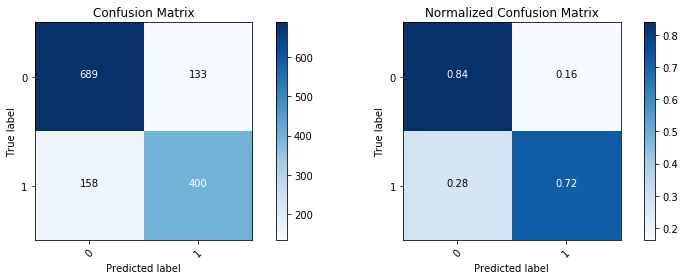

In [35]:
plot_side_by_side_confusion_matrix(y_test,naive_predictions)

No handles with labels found to put in legend.


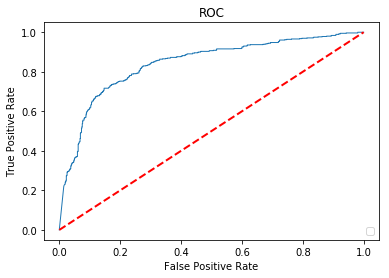

In [38]:
plot_roc_curve(y_test, naive_predictions_probs[:,1])

### AdaBoost Classifier

Let's try to create a AdaBoost Classifier and fit it to the data:

In [60]:
adaboost_model = AdaBoostClassifier(n_estimators=50, learning_rate=0.5)

In [61]:
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=None)

In [62]:
adaboost_predictions = adaboost_model.predict(X_test)

### Model Evaluations

In [63]:
print(classification_report(y_test, adaboost_predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       822
           1       0.96      0.92      0.94       558

   micro avg       0.95      0.95      0.95      1380
   macro avg       0.95      0.95      0.95      1380
weighted avg       0.95      0.95      0.95      1380



In [64]:
adaboost_predictions_probs = adaboost_model.predict_proba(X_test)

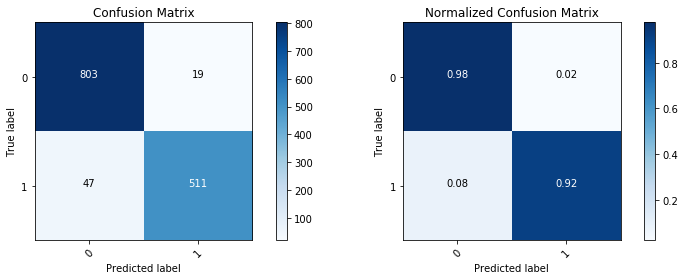

In [65]:
plot_side_by_side_confusion_matrix(y_test,adaboost_predictions)

No handles with labels found to put in legend.


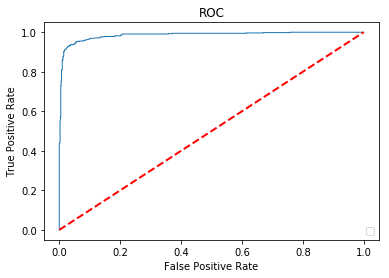

In [66]:
plot_roc_curve(y_test, adaboost_predictions_probs[:,1])

As it can be seen in the evaluation results, the AdaBoost classifier has performed much better than the naive bayes classifier and on the test data is able to detect spam/not spams with a very good accuracy.